In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
from gwaxion import physics
import pandas as pd
import lal

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

/home/misi/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/misi/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/misi/.local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/misi/.local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/misi/.local/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary inco

In [2]:
# scalar timescales (approximate formulas from paper)

def tinst(m, alpha, chi):
    return 25. * lal.DAYSID_SI * (10*lal.MSUN_SI/m) * (0.1/alpha)**9 / chi

def tgw(m, alpha, chi):
    return (6.5E4) * lal.YRSID_SI * (10*lal.MSUN_SI/m) * (0.1/alpha)**15 / chi


/home/misi/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


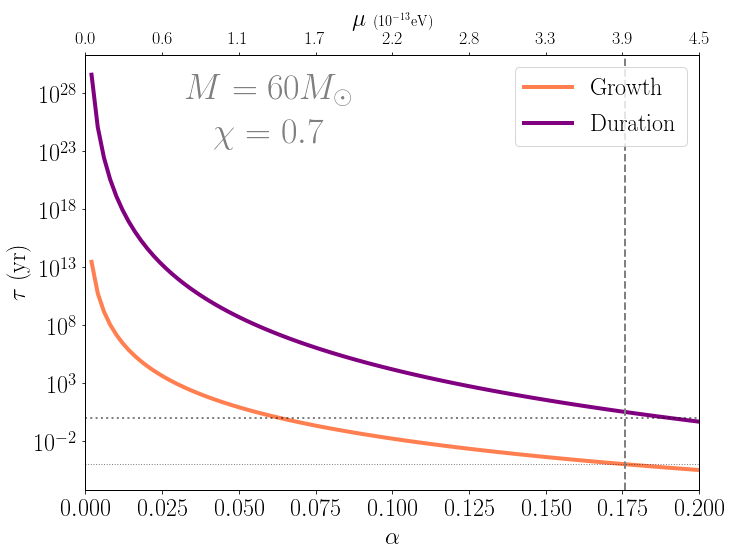

In [3]:
mbh_ex = 60
mbh = mbh_ex*lal.MSUN_SI
chi = 0.7
alphas = np.linspace(0, 0.2, 100)

fig, ax = plt.subplots(1, figsize=(11,8))
ax2 = ax.twiny()

ax.plot(alphas, tinst(mbh, alphas, chi)/lal.YRSID_SI, label='Growth', lw=4, c='coral')
ax.plot(alphas, tgw(mbh, alphas, chi)/lal.YRSID_SI, label='Duration', lw=4, c='purple')


ax.axhline(1, ls=':', c='k', lw=2, alpha=0.5)
ax.axhline(0.0001, ls=':', c='k', lw=1, alpha=0.5)
ax.axvline(0.176, ls='--', c='gray', lw=2)

ax.set_xlim(0, 0.2)
ax.set_yscale('log')
ax.set_ylabel(r'$\tau$ (yr)')
ax.set_xlabel(r'$\alpha$')

ax.annotate(r'$M=60 M_\odot$'+'\n'+r'$\chi=0.7$', xy=(0.3, 0.95), xycoords="axes fraction", 
            ha='center', va='top', fontsize=36, color='gray')

ax.legend(loc='upper right')

# add boson mass scale
def mu_alpha(alpha):
    return physics.Alpha(alpha=alpha, m_bh=mbh_ex).m_b_ev
mu_ticks = mu_alpha(ax.get_xticks())/1E-13
ax2.set_xticks(mu_ticks)
ax2.set_xticklabels(['%.1f' % x for x in mu_ticks])
ax2.set_xlim(mu_alpha(np.array(ax.get_xlim()))/1E-13)
ax2.set_xlabel(r'$\mu$ {\Large ($10^{-13}$eV)}')
ax2.tick_params(labelsize=18) 

#ax.grid(True)

fig.savefig('plot_tau_alpha.pdf', bbox_inches='tight')

plt.show()
plt.close()

In [4]:
print tinst(mbh, 0.176, chi)/60
print tgw(mbh, 0.176, chi)/lal.YRSID_SI

52.7535591751
3.21346851431


In [5]:
print tinst(mbh, 0.1, chi)/lal.DAYSID_SI
print tgw(mbh, 0.1, chi)/lal.YRSID_SI

5.95238095238
15476.1904762


In [6]:
n_mass = 1000
n_alpha = 1000

mbhs_array = np.logspace(0, 3, n_mass).reshape(n_mass, 1)
alphas_array = np.linspace(0.01, 0.2, n_alpha).reshape(1, n_alpha)

mbhs = np.repeat(mbhs_array, n_alpha, axis=1)
alphas = np.repeat(alphas_array, n_mass, axis=0)

In [7]:
# get maximum amplitude per mass
h0s, fgws = physics.h0_scalar_brito(mbhs_array, alphas_array, chi_i=chi, d=5E6*lal.PC_SI)

df1 = pd.DataFrame({'alpha': alphas.flatten(), 'mbhs': mbhs.flatten(), 'h0': h0s.flatten()})

grouped = df1.groupby('mbhs')
amaxs = []
for mbh in mbhs_array.flatten():
    df_mbh = grouped.get_group(mbh)
    amaxs.append(df_mbh['alpha'][df_mbh['h0']==df_mbh['h0'].max()].iloc[0])

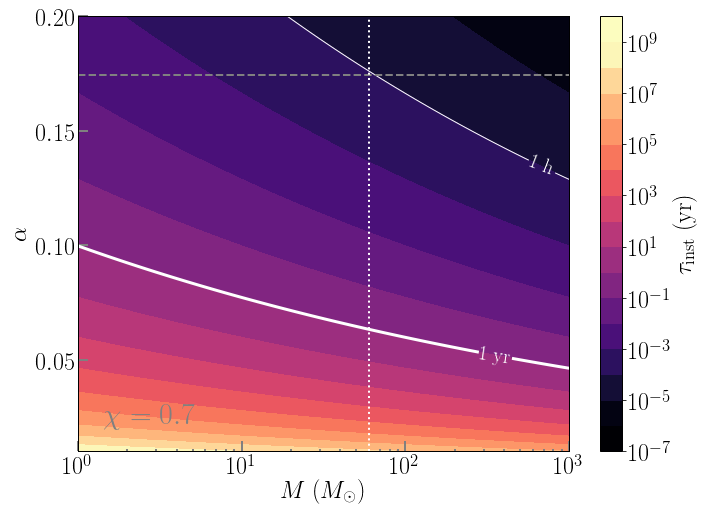

In [45]:
tinsts = tinst(mbhs*lal.MSUN_SI, alphas, chi)/lal.YRSID_SI

norm = matplotlib.colors.LogNorm(vmin=tinsts.min(), vmax=tinsts.max())

fig, ax = plt.subplots(1, figsize=(11,8))

cm = ax.contourf(mbhs, alphas, tinsts, cmap='magma', locator=ticker.LogLocator(numticks=18,base=10), norm=norm)

ax.set_xscale('log')

cs = ax.contour(mbhs, alphas, tinsts, levels = [0.0001,1], colors=('white',),linestyles=('-','-'), linewidths=(1,3))

strs = ['1 h', '1 yr']
fmt = {l: s for l, s in zip(cs.levels, strs)}
plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

#cb_ticks = np.logspace(-30, -24, 7)# np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm inst}$ (yr)')#, ticks=cb_ticks)

ax.plot(mbhs_array.flatten(), amaxs, '--', color='gray', lw=2)

ax.axvline(mbh_ex, ls=':', c='w', lw=2)

yticks = np.arange(0, 0.25, 0.05)[1:]
ax.set_yticks(yticks)

ax.set_xscale('log')
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$M$ $(M_\odot)$')

ax.tick_params(axis='both', color='0.5', which='both', width=2, direction='in')
ax.tick_params(axis='both', color='0.5', length=10, direction='in')

ax.annotate(r'$\chi=0.7$', xy=(0.05, 0.05), xycoords="axes fraction", 
            ha='left', va='bottom', fontsize=30, color='0.5')

fig.savefig('cmap_alpha_mbh_tinst.pdf', bbox_inches='tight')

plt.show()
plt.close()

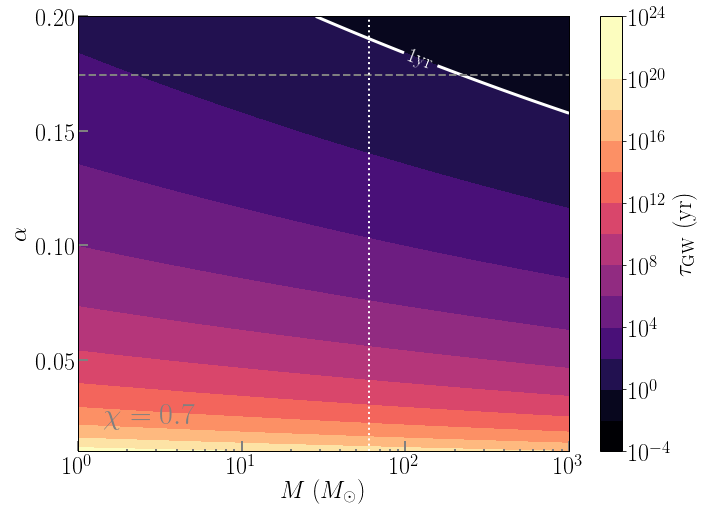

In [55]:
tgws = tgw(mbhs*lal.MSUN_SI, alphas, chi)/lal.YRSID_SI

norm = matplotlib.colors.LogNorm(vmin=tgws.min(), vmax=tgws.max())

fig, ax = plt.subplots(1, figsize=(11,8))
ax.set_xscale('log')

cm = ax.contourf(mbhs, alphas, tgws, cmap='magma', norm=norm, locator=ticker.LogLocator(numticks=18,base=10), )
cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm GW}$ (yr)')#, ticks=cb_ticks)

ax.plot(mbhs_array.flatten(), amaxs, '--', color='gray', lw=2)
cs = ax.contour(mbhs, alphas, tgws, levels = [0.0001,1], colors=('white',),linestyles=('-','-'), linewidths=(3,))
ax.axvline(mbh_ex, ls=':', c='w', lw=2)

strs = ['1yr', '1 yr']
fmt = {l: s for l, s in zip(cs.levels, strs)}
plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$M$ $(M_\odot)$')

yticks = np.arange(0, 0.25, 0.05)[1:]
ax.set_yticks(yticks)

ax.tick_params(axis='both', color='0.5', which='both', width=2, direction='in')
ax.tick_params(axis='both', color='0.5', length=10, direction='in')

ax.annotate(r'$\chi=0.7$', xy=(0.05, 0.05), xycoords="axes fraction", 
            ha='left', va='bottom', fontsize=30, color='0.5')

fig.savefig('cmap_alpha_mbh_tgw.pdf', bbox_inches='tight')

plt.show()
plt.close()

In [10]:
# make plot of region for which t_inst < 1yr < t_gw

df1['tinst'] = tinsts.flatten()
df1['tgw'] = tgws.flatten()

df2 = df1[(df1['tinst']<=1) & (1<= df1['tgw'])]

In [11]:
print len(df1)
print len(df2)

1000000
626074


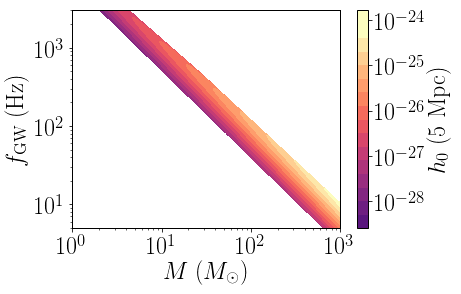

In [12]:
h0s_ma = np.ma.masked_array(h0s, mask=((tinsts>1)|(tgws<1)))

norm = matplotlib.colors.LogNorm(vmin=1E-30, vmax=h0s_ma.max())

cm = plt.contourf(mbhs,fgws, h0s_ma, cmap='magma', norm=norm, locator=ticker.LogLocator(numticks=100,base=2))
# fmt = ticker.LogFormatterMathtext()
# fmt.create_dummy_axis()
# plt.clabel(cs, cs.levels, inline=True, fontsize=8, fmt=fmt, loc='best')
cb_ticks = np.logspace(-30, -24, 7)
cb = plt.colorbar(cm, norm=norm, label=r'$h_0$ (5 Mpc)', ticks=cb_ticks)
plt.ylim(5, 3E3)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$f_{\rm GW}$ (Hz)')
plt.xlabel(r'$M$ $(M_\odot)$')
#ax = plt.gca()
#ax.patch.set_facecolor('k')
plt.show()
plt.close()

In [13]:
np.min(tgws/tinsts)

14879.166323763053